In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from ast import literal_eval
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [6]:
main_df = pd.read_csv("../data/animes_better.csv")
columns_to_drop = ['title', 'aired', 'episodes', 'members', 'ranked', 'score', 'link', 'img_url']
main_df = main_df.drop(columns=columns_to_drop)
main_df

,uid,synopsis,genre,popularity,Type,Producers,Studios,Source,Themes,Demographic,Duration,Favorites,Streaming Platforms
0,28891,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",141,TV,"['Dentsu', 'Mainichi Broadcasting System', 'Mo...",['Production I.G'],Manga,"['School', 'Team Sports']",Shounen,24.0,15764,['Crunchyroll']
1,23273,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",28,TV,"['Aniplex', 'Dentsu', 'Kodansha', 'Fuji TV', '...",['A-1 Pictures'],Manga,"['Love Polygon', 'Music', 'School']",Shounen,22.0,86357,"['Crunchyroll', 'Netflix']"
2,34599,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",98,TV,"['AT-X', 'Takeshobo', 'Sony Music Communicatio...",['Kinema Citrus'],Web manga,['Theme Unknown'],Demographic Unknown,25.0,44597,"['Crunchyroll', 'HIDIVE', 'Netflix']"
3,5114,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",4,TV,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...",['Bones'],Manga,['Theme Unknown'],Shounen,24.0,227331,['Crunchyroll']
4,31758,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",502,Movie,"['Aniplex', 'Kodansha']",['Shaft'],Light novel,['Theme Unknown'],Demographic Unknown,83.0,7588,['No Streaming Platform']
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,10075,All-new animation offered throughout UNIQLO cl...,"['Action', 'Comedy', 'Super Power', 'Martial A...",2382,OVA,['Producer Unknown'],['Pierrot'],Manga,['Theme Unknown'],Shounen,6.0,85,['No Streaming Platform']
16212,35828,High school student Sora Kashiwagi is accustom...,"['Slice of Life', 'Comedy', 'Supernatural']",1648,TV,"['TBS', 'Grooove', 'Nichion', 'Exit Tunes', 'O...",['8bit'],Web manga,"['Mythology', 'Pets', 'School']",Demographic Unknown,24.0,753,['Crunchyroll']
16213,10378,"After regaining her squid-like abilities, Ika ...","['Slice of Life', 'Comedy', 'Shounen']",1547,TV,"['TV Tokyo', 'Lantis', 'Pony Canyon', 'TV Toky...",['Diomedéa'],Manga,['Anthropomorphic'],Shounen,24.0,178,"['Crunchyroll', 'HIDIVE']"
16214,33082,"For years, the Niflheim Empire and the kingdom...",['Action'],2154,Movie,['Square Enix'],['Square Enix Visual Works'],Game,['Theme Unknown'],Demographic Unknown,115.0,154,['No Streaming Platform']


In [7]:
main_df['synopsis'] = main_df['synopsis'].fillna('')

stop_words = set(stopwords.words('english'))
stop_words.update(['anime','source'])
main_df['synopsis_clean'] = main_df['synopsis'].str.replace('[Written by MAL Rewrite]', '', regex=False)

def preprocess(text):
    tokens = [word for word in text.lower().split() if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

main_df['synopsis_clean'] = main_df['synopsis_clean'].apply(preprocess)

def extract_keywords(text):
    if not text.strip(): 
        return []
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
    try:
        tfidf_matrix = vectorizer.fit_transform([text])
        feature_names = vectorizer.get_feature_names_out()
        tfidf_scores = zip(feature_names, tfidf_matrix.toarray()[0])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords = [word for word, score in sorted_tfidf_scores[:5]]
        return top_keywords
    except ValueError:
        return []

main_df['keywords'] = main_df['synopsis_clean'].apply(extract_keywords)

main_df[['uid','synopsis_clean', 'keywords']].head(10)

,uid,synopsis_clean,keywords
0,28891,following participation karasuno high school v...,"[volleyball, hope, karasuno, team, teams]"
1,23273,music accompanies path human prodigious pianis...,"[kousei, music, accompanies, note, passing]"
2,34599,gaping chasm stretching depths filled mysterio...,"[chasm, come, mysterious, whistle, white]"
3,5114,order something something equal value must alc...,"[alphonse, brothers, edward, colonel, equivalent]"
4,31758,helping revive legendary vampire koyomi ararag...,"[araragi, vampire, possible, turn, powerful]"
5,37510,shigeo kageyama maturing understanding role su...,"[reigen, supernatural, mob, psychic, remains]"
6,199,chihiro ogino less pleased parents discover ab...,"[parents, chihiro, meets, place, pleased]"
7,38000,ever since death burden supporting family fall...,"[tanjirou, family, demons, able, mysterious]"
8,35247,following encounter oddity specialist izuko hi...,"[araragi, student, alarmingly, mystery, oddity]"
9,2904,one year passed since black failed uprising ho...,"[black, accept, masked, mastermind, memory]"


In [8]:
main_df = main_df.drop(['synopsis', 'synopsis_clean'], axis=1)

In [9]:
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

def encode_multilabel_predictor(df, predictor):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[predictor])
    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
    return encoded_df, mlb.classes_

In [10]:
encoded_genre_df, genre_classes = encode_multilabel_predictor(main_df, 'genre')

encoded_df = pd.concat([encoded_genre_df, main_df.drop(columns=['genre'])], axis=1)

X = encoded_df[genre_classes]
y = encoded_df['popularity']

valid_indices = X.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Genre - MSE: {mse:.2f}, R²: {r2:.2f}")

Genre - MSE: 12537008.57, R²: 0.44


In [15]:
platform_df = main_df[(main_df['Streaming Platforms'] != "['Platform Unknown']") & (main_df['Streaming Platforms'] != "['']")].copy()
platform_df.loc[:, 'Streaming Platforms'] = platform_df['Streaming Platforms'].apply(safe_literal_eval)
all_platforms = [platform for sublist in platform_df['Streaming Platforms'] for platform in sublist]
platform_counts = Counter(all_platforms)
platform_df.loc[:, 'Platform_Count'] = platform_df['Streaming Platforms'].apply(lambda x: sum([platform_counts[platform] for platform in x]))

encoded_df = pd.concat([encoded_genre_df, main_df.drop(columns=['genre'])], axis=1)
encoded_df = pd.merge(encoded_df, platform_df[['Platform_Count']], left_index=True, right_index=True)

X = pd.concat([encoded_df[genre_classes], encoded_df[['Platform_Count']]], axis=1)
y = encoded_df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Combined Genre and Platform Count - MSE: {mse:.2f}, R²: {r2:.2f}")

Combined Genre and Platform Count - MSE: 10590810.14, R²: 0.53


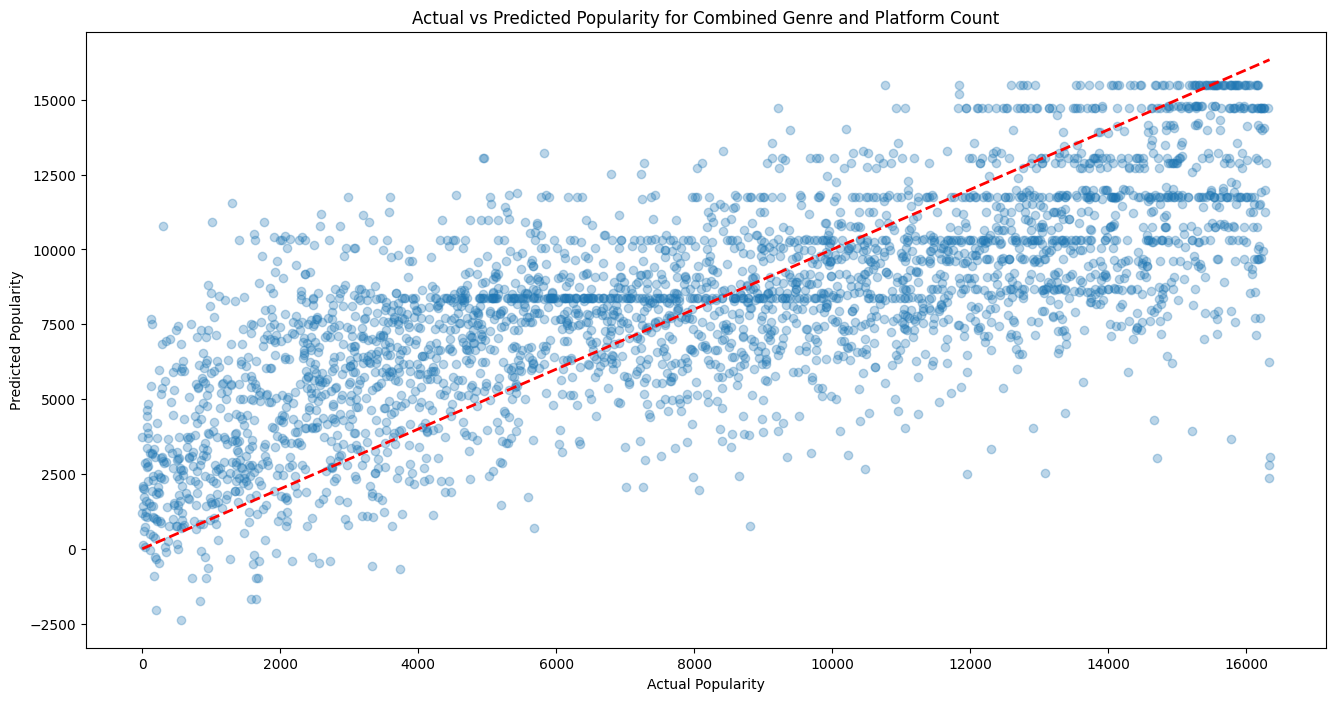

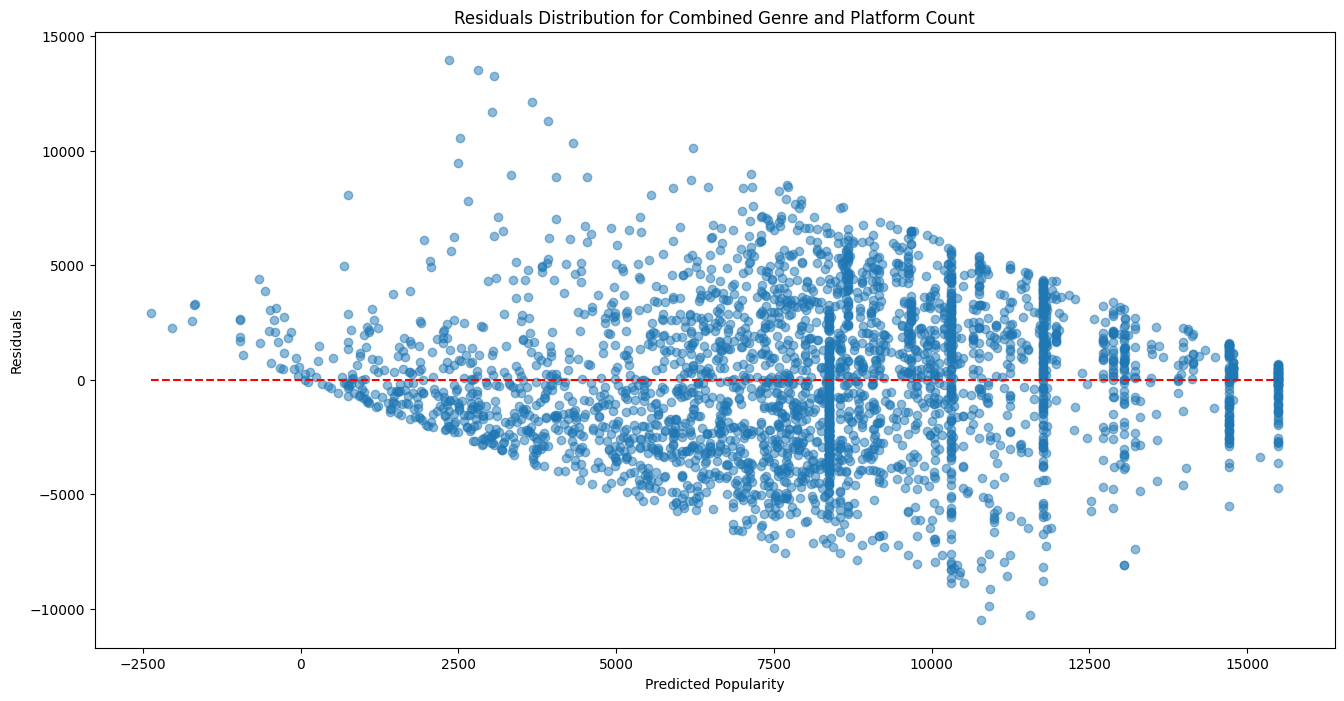

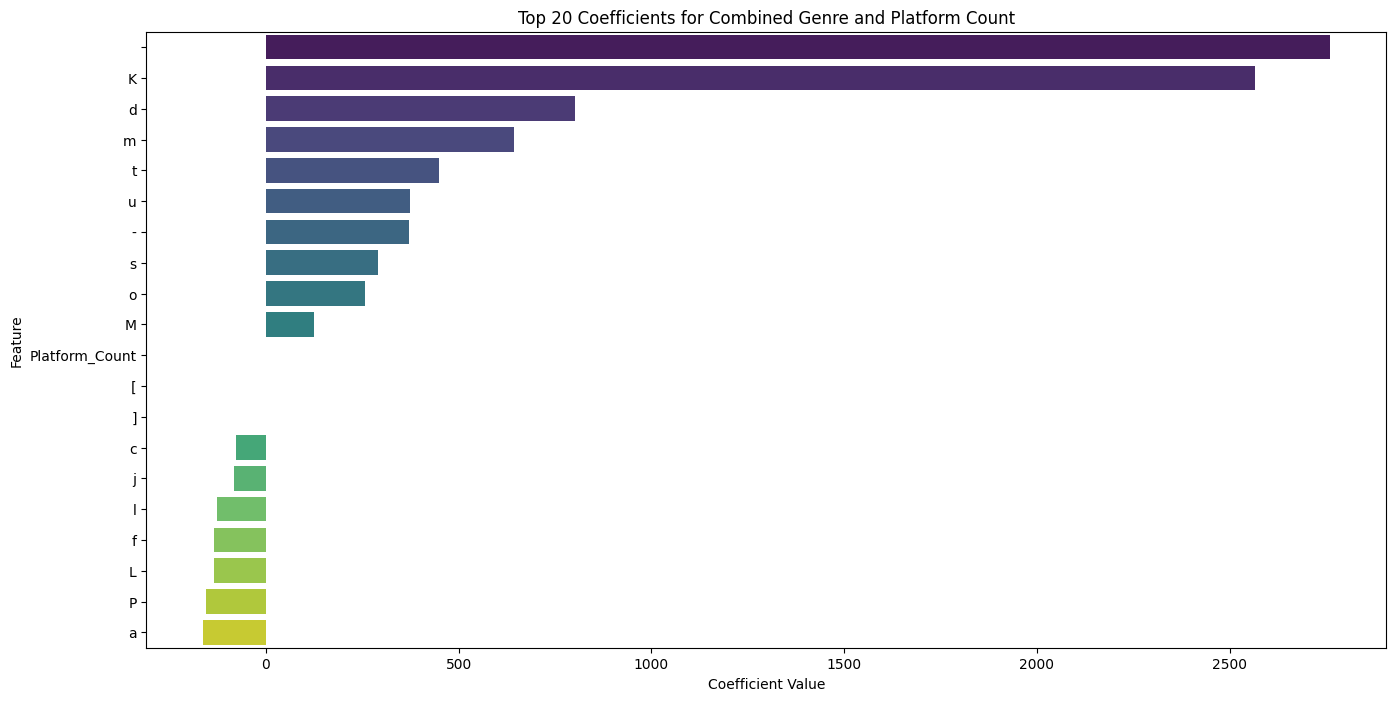

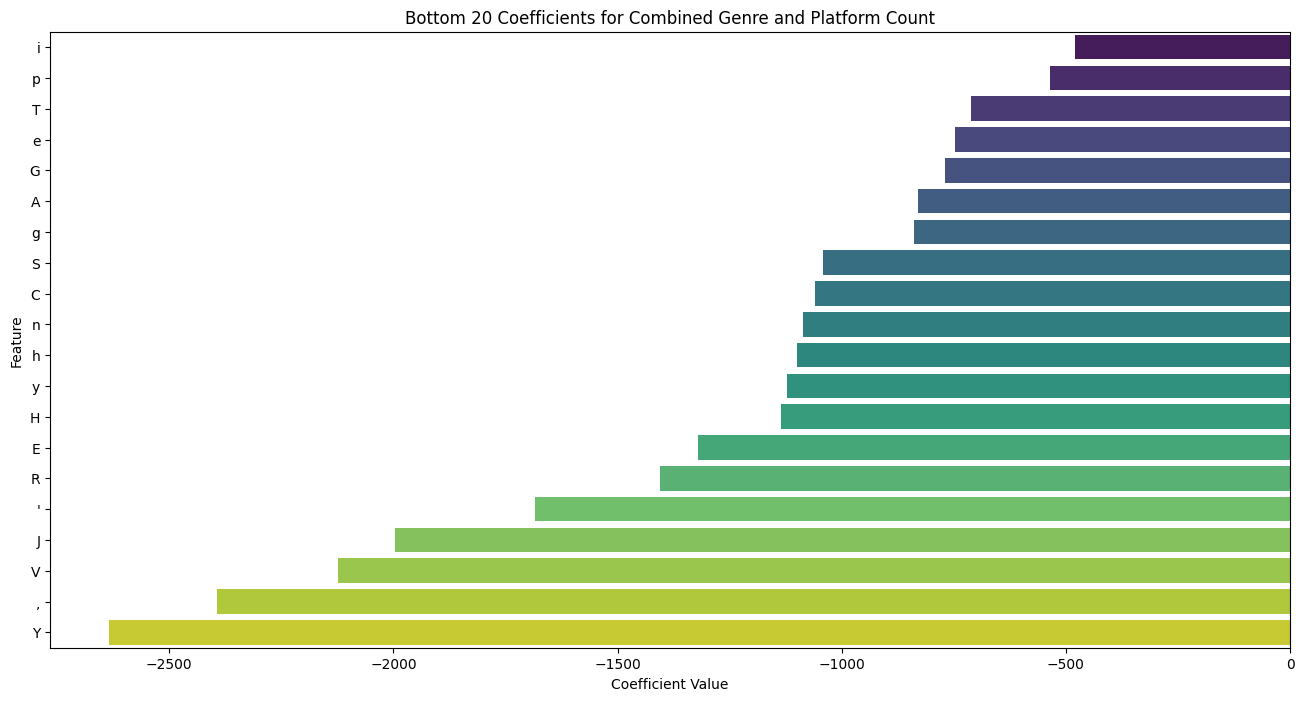

In [18]:
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity for Combined Genre and Platform Count')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(16, 8))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Distribution for Combined Genre and Platform Count')
plt.show()

coeffs = model.coef_
coeff_names = list(X.columns)
assert len(coeffs) == len(coeff_names), "Length of coefficients and feature names do not match."

coeff_df = pd.DataFrame({'Feature': coeff_names, 'Coefficient': coeffs})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)


plt.figure(figsize=(16, 8))
sns.barplot(x=coeff_df['Coefficient'].head(20), y=coeff_df['Feature'].head(20), hue=coeff_df['Feature'].head(20), palette="viridis")
plt.xlabel('Coefficient Value')
plt.title('Top 20 Coefficients for Combined Genre and Platform Count')
plt.show()

plt.figure(figsize=(16, 8))
sns.barplot(x=coeff_df['Coefficient'].tail(20), y=coeff_df['Feature'].tail(20), hue=coeff_df['Feature'].tail(20), palette="viridis")
plt.xlabel('Coefficient Value')
plt.title('Bottom 20 Coefficients for Combined Genre and Platform Count')
plt.show()

In [ ]:
producer_df = main_df[(main_df['Producers'] != "['Producer Unknown']") & (main_df['Producers'] != "['']")].copy()

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

producer_df.loc[:, 'Producers'] = producer_df['Producers'].apply(safe_literal_eval)

all_producers = [producer for sublist in producer_df['Producers'] for producer in sublist]
producer_counts = Counter(all_producers)

producer_df.loc[:, 'Producer_Count'] = producer_df['Producers'].apply(lambda x: sum([producer_counts[producer] for producer in x]))

X = producer_df[['Producer_Count']]
y = producer_df['popularity']